In [ ]:
spark

In [1]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import PipelineModel
from pyspark.sql.functions import *
from google.cloud import storage

In [2]:
model_path = 'gs://my-bigdata-project-sj/models/flight_delay_ridge_regression_model'
pipeline = PipelineModel.load(model_path)

#Extract model from Pipeline 
mymodel = pipeline.stages[-1]

In [ ]:
print("Coefficients: ", mymodel.coefficients)

In [ ]:
print("Paramter: ", mymodel.extractParamMap)

In [ ]:
print("ElasticParam: ",mymodel.getElasticNetParam())

In [ ]:
print("RegParam: ",mymodel.getRegParam())

In [3]:
output_file_path="gs://my-bigdata-project-sj/trusted/trusted_flight_delay.parquet"
transformed_sdf = spark.read.parquet(output_file_path)

In [ ]:
trainingData, testData = transformed_sdf.randomSplit([0.70, 0.3], seed=42)

In [ ]:
transformed_sdf.printSchema()

In [ ]:
monthly_delay_sdf=transformed_sdf.where(col('DepDelayMinutes') >= 60).groupby('Month').count().sort('Month').select('Month','count')
monthly_delay_sdf.show(5)

In [ ]:
monthly_df=monthly_delay_sdf.toPandas()

In [ ]:
#Graph that shows which month has the month delays
fig = plt.figure(facecolor='white')
#Graph month and number of delay
plt.bar(monthly_df['Month'], monthly_df['count'])

#Graph labels 
plt.xlabel("Month")
plt.ylabel("Number of Delay > 1hr ")
plt.title("Number of Delay by Month")
plt.xticks([ 1, 2, 3, 4 , 5, 6, 7, 8, 9, 10, 11, 12], ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December'])
plt.xticks(rotation=90, ha='right')
plt.savefig("delay_month_matplotlib.png")
plt.show()

In [ ]:
# Save the plot to GCS
import io
from google.cloud import storage

# Create a buffer t
img_data = io.BytesIO()
# Write the Matplotlib figure to the buffer
fig.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)
# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-sj')

# Create a blob to hold the data. 
blob = bucket.blob("/figures/delay_month.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

In [ ]:
airline_delay_sdf=transformed_sdf.where(col('DepDelayMinutes') >= 60).groupby('Airline').count().orderBy(col("count").desc()).limit(10).select('Airline','count')
airline_delay_sdf.show(10)

In [ ]:
airline_df=airline_delay_sdf.toPandas()

In [ ]:
#Graph that shows the Airline with the most delays
fig2 = plt.figure(facecolor='white')
plt.bar(airline_df['Airline'], airline_df['count'])

plt.xlabel("Airline")
plt.ylabel("Number of Delay > 1hr ")
plt.title("Most Number of Delay by Airline")
plt.xticks(rotation=90, ha='right')
plt.savefig("most_airline_delay.png")
plt.show()

In [ ]:
# buffer to hold the figure
img_data = io.BytesIO()
# Write the Matplotlib figure to the buffer
fig2.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)
# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-sj')

# Create a blob to hold the data.
blob = bucket.blob("/figures/most_airline_delay.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

In [ ]:
# Graph the top 10 airlines with the least delays
min_airline_delay_sdf=transformed_sdf.where(col('DepDelayMinutes') >= 60).groupby('Airline').count().orderBy(col("count").asc()).limit(10).select('Airline','count')
min_airline_delay_sdf.show(10)

In [ ]:
min_airline_df=min_airline_delay_sdf.toPandas()

In [ ]:
#Graph that shows the Airline with the most delays
fig3 = plt.figure(facecolor='white')
plt.bar(min_airline_df['Airline'], min_airline_df['count'])

plt.xlabel("Airline")
plt.ylabel("Number of Delay > 1hr ")
plt.title("Least Number of Delay by Airline")
plt.xticks(rotation=50, ha='right')
plt.savefig("least_airline_delay.png")
plt.show()

In [ ]:
#  buffer to hold the figure
img_data = io.BytesIO()
# Write the Matplotlib figure to the buffer
fig3.savefig(img_data, format='png', bbox_inches='tight')

# Rewind the pointer to the start of the data
img_data.seek(0)
# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-sj')

# Create a blob to hold the data. 
blob = bucket.blob("/figures/least_airline_delay.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

In [4]:
sample_sdf=transformed_sdf.sample(False,0.15)

In [5]:
regression_df=sample_sdf.select('DepDelayMinutes','prediction').toPandas()

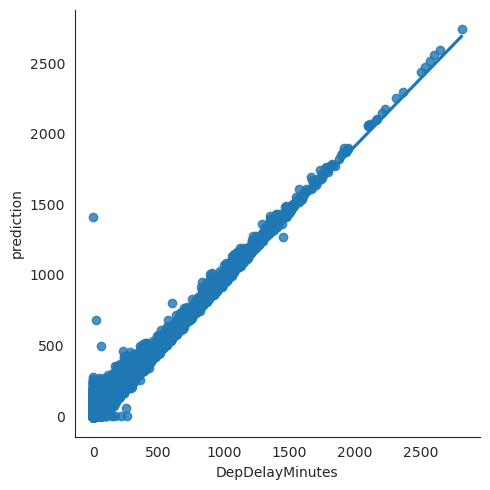

In [6]:
# Set the style for Seaborn plots
sns.set_style("white")
relationship_plot=sns.lmplot(x='DepDelayMinutes', y='prediction', data=regression_df)

In [8]:
# Saving Seaborn Relationship plot to GCS

img_data = io.BytesIO()
# Figure to the buffer
relationship_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-sj')

# Create a blob to hold the data. 
blob = bucket.blob("/figures/relationship_plot.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

In [10]:
regression_df['residuals'] = regression_df['DepDelayMinutes'] - regression_df['prediction']

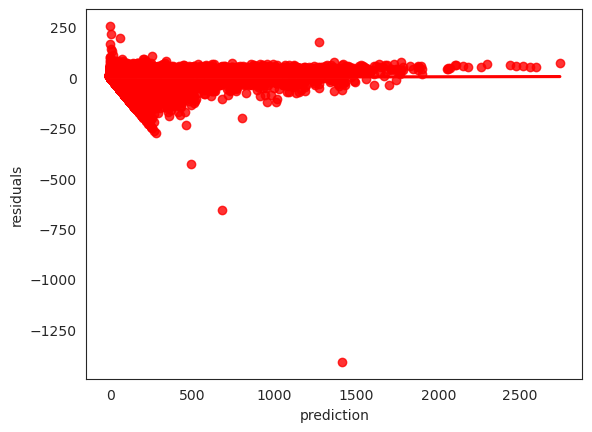

In [12]:
# Set the style for Seaborn plots
sns.set_style("white")

# Create a relationship plot between tip and prediction
residual_plot=sns.regplot(x = 'prediction', y = 'residuals', data = regression_df, scatter = True, color = 'red')

In [17]:
# Saving Seaborn Relationship plot to GCS

img_data = io.BytesIO()
# Figure to the buffer
residual_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-bigdata-project-sj')

# Create a blob to hold the data. 
blob = bucket.blob("/figures/residual_plot.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

AttributeError: 'Axes' object has no attribute 'savefig'